In [194]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits
from tqdm import tqdm
import itertools

import powerlaw
import datetime
import cv2

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory, discretizeTrajectoryIndices

sys.path.append('../../ant_simulation/')
from ant_sim import autocorrelation

# Update source files before running each cell
%load_ext autoreload
%autoreload 2
    
# Color for control/test pairs
colors = ['tab:orange', 'tab:green']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in data

In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-01-01.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 15 seconds.
minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████| 1434/1434 [00:02<00:00, 716.12it/s]

Loaded 441 segments!


# Compare pretreatments (isolated vs together)

In [3]:
controlIndices = np.where([metadataArr[i]["pretreatment"] == 'together' for i in range(len(metadataArr))])[0]
testIndices = np.where([metadataArr[i]["pretreatment"] == 'isolated' for i in range(len(metadataArr))])[0]

variable = 'Pretreatment'
controlLabel = 'Together'
testLabel = 'Isolated'

saveFileBase = 'pretreatment_test'

print(controlIndices)
print(testIndices)

[  0   1   2   3   4   5   8   9  10  11  13  15  16  17  18  19  20  22
  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  94  95  96  97  98
  99 100 101 102 103 105 106 107 108 109 110 112 113 114 115 116 118 119
 120 121 122 124 125 126 127 128 129 130 131 132 133 134 135 137 138 139
 140 142 143 144 145 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 170 171 172 173 174 175 176 177 178
 179 180 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 206 207 208 209 210 211 213 214 215 216 217
 218 220 221 222 223 224 226 227 228 230 231 232 233 235 236 237 238 239
 240 241 242 244 245 246 247 248 249 250 251 252 253 254 255 256 257 259
 260 261 262 263 266 269 271 272 273 274 275 276 27

# Compare time of day

In [7]:
collectionTimeArr = np.array([datetime.datetime.strptime(metadataArr[i]["collection_time"], '%H:%M') for i in range(len(metadataArr))])
noonTime = datetime.datetime.strptime('12:00', '%H:%M')

controlIndices = np.where(collectionTimeArr <= noonTime)[0]
testIndices = np.where(collectionTimeArr > noonTime)[0]

variable = 'Time of day'
controlLabel = 'Morning'
testLabel = 'Afternoon'

saveFileBase = 'time_of_day_test'

print(controlIndices)
print(testIndices)

[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  34  35  39  40  41  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  64
  65  66  67  68  69  71  74  75  76  80  81  82  84  85  86  87  88  89
  91  92  93  97  98  99 100 101 102 103 104 105 106 108 109 111 113 114
 115 116 117 118 120 121 122 123 124 125 126 127 128 129 131 132 133 134
 135 136 137 138 141 142 143 144 145 146 147 149 151 152 153 154 155 156
 157 159 160 161 162 163 166 169 170 171 172 176 177 178 180 181 183 184
 186 187 188 189 190 191 193 194 195 199 200 201 204 205 206 208 209 210
 212 213 216 219 220 221 222 223 224 225 226 228 229 230 232 234 235 238
 239 241 242 243 244 245 246 247 248 249 251 253 257 258 261 262 263 264
 265 267 268 270 272 276 278 280 281 283 284 286 287 289 290 291 294 296
 297 302 303 304 308 311 315 317 318 322 323 326 328 330 331 333 336 337
 338 339 340 341 343 349 350 352 358 360 363 365 37

# Compare cleaned vs uncleaned

In [11]:
controlIndices = np.where([metadataArr[i]["cleaned"] for i in range(len(metadataArr))])[0]
testIndices = np.where([~metadataArr[i]["cleaned"] for i in range(len(metadataArr))])[0]

variable = 'Cleaning'
controlLabel = 'Cleaned'
testLabel = 'Not cleaned'

saveFileBase = 'cleaning_test'

print(controlIndices)
print(testIndices)

[  0   1   2   3   6   7  10  11  12  14  15  21  22  23  24  27  31  32
  35  36  38  40  41  42  45  46  52  53  54  55  56  59  60  63  64  65
  67  69  74  77  82  83  85  86  88  89  92  93  99 100 101 102 104 105
 106 111 112 113 115 116 117 118 119 120 121 122 123 125 127 128 131 132
 133 134 135 136 141 142 144 145 146 151 152 153 155 157 162 166 168 169
 171 177 180 181 184 185 186 187 189 191 192 193 194 196 199 205 206 209
 212 214 216 219 220 221 223 224 225 226 227 228 229 230 234 235 241 242
 243 244 247 248 249 251 255 256 258 264 265 267 268 269 270 276 278 280
 281 283 284 286 287 289 290 291 296 297 302 307 308 311 315 317 318 323
 330 331 333 338 340 341 343 350 352 358 360 363 365 370 379 388 396 397
 406 407 411 412 413 422 433 437 440]
[  4   5   8   9  13  16  17  18  19  20  25  26  28  29  30  33  34  37
  39  43  44  47  48  49  50  51  57  58  61  62  66  68  70  71  72  73
  75  76  78  79  80  81  84  87  90  91  94  95  96  97  98 103 107 108
 109 110 114 

# Discretize and plot

In [12]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
# This corresponds to an angle of arccos(c)
cArr = [0.5]

# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = [3] # mm/s

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 3 # mm
minStepsPerRun = 5 # frames

controlDiscreteDataArr = []
controlDiscreteStepSizeArr = []
controlWaitTimeArr = []
controlRunTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    controlDiscreteDataArr.append([])
    controlDiscreteStepSizeArr.append([])
    controlWaitTimeArr.append([])
    controlRunTimeArr.append([])

    for j in tqdm(range(len(controlIndices))):
        data = dataArr[controlIndices[j]]
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(data,
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[controlIndices[j]]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        controlDiscreteDataArr[-1].append(discreteTraj)
        
        controlDiscreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        controlWaitTimeArr[-1].append(waitingTimes)
        controlRunTimeArr[-1].append(runTimes)

testDiscreteDataArr = []
testDiscreteStepSizeArr = []
testWaitTimeArr = []
testRunTimeArr = []

for i in range(len(cArr)):
    testDiscreteDataArr.append([])
    testDiscreteStepSizeArr.append([])
    testWaitTimeArr.append([])
    testRunTimeArr.append([])

    for j in tqdm(range(len(testIndices))):
        data = dataArr[testIndices[j]]

        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(data,
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[testIndices[j]]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        testDiscreteDataArr[-1].append(discreteTraj)
        
        testDiscreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        testWaitTimeArr[-1].append(waitingTimes)
        testRunTimeArr[-1].append(runTimes)

100%|█████████████████████████████████████████| 252/252 [00:57<00:00,  4.37it/s]


In [13]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=0):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))

    velocityArr = velocityArr[velocityMagnitudes > minVelocityThreshold]
    velocityMagnitudes = velocityMagnitudes[velocityMagnitudes > minVelocityThreshold]

    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

controlAngleArr = []
testAngleArr = []

for i in range(len(cArr)):
    controlAngleArr.append([])

    for j in tqdm(range(len(controlIndices))):
        discreteData = controlDiscreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/metadataArr[controlIndices[j]]["fps"],
                               minVelocityThreshold=velocityThresholdArr[i])

        controlAngleArr[-1].append(angles)

for i in range(len(cArr)):
    testAngleArr.append([])

    for j in tqdm(range(len(testIndices))):
        discreteData = testDiscreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/metadataArr[testIndices[j]]["fps"],
                               minVelocityThreshold=velocityThresholdArr[i])

        testAngleArr[-1].append(angles)

100%|███████████████████████████████████████| 252/252 [00:00<00:00, 1590.18it/s]


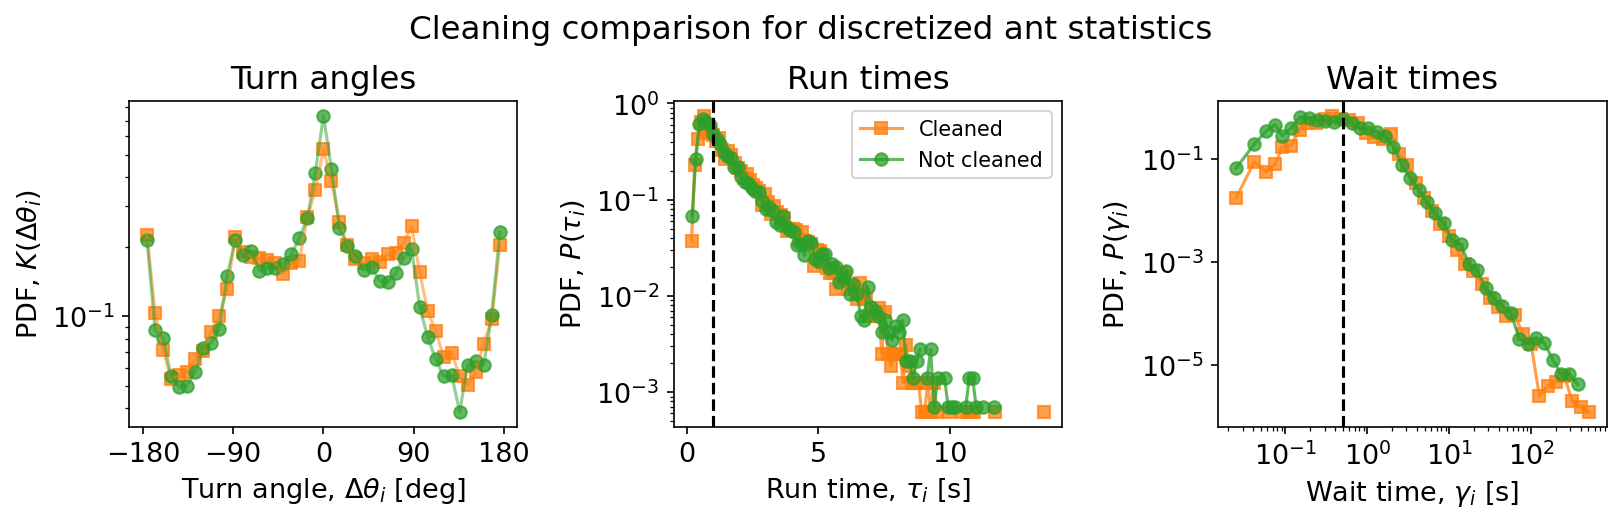

In [14]:
# For angles
numBins = 45
bins = np.linspace(-np.pi, np.pi, numBins+1)
binArr = (bins[1:] + bins[:-1])/2

# For run times
# Minimum time; just a reasonable (empirical) value
xMinRunTime = 1 # [s]
# Maximum time
xMaxRunTime = None

# For waiting times
# Minimum time; should be the smallest time we consider
# significant for a discretized run:
xMinWaitTime = maximumTimeSkip / metadataArr[0]["fps"] * 3
# Maximum time should be the length of a trial
xMaxWaitTime = 1200 # [s], 20 minutes

fig, ax = plt.subplots(1, 3, figsize=(11,3.75))

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    controlAngles = np.array([a for aa in controlAngleArr[i] for a in aa])
    testAngles = np.array([a for aa in testAngleArr[i] for a in aa])
    
    meanDist, meanBins = np.histogram(controlAngles, bins=bins, density=True)
    ax[0].scatter(binArr*180/np.pi, meanDist, c=colors[0], label=controlLabel if i == 0 else None, marker='s', alpha=0.75)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].plot(binArr*180/np.pi, meanDist, '-', alpha=0.5, c=colors[0])
    
    meanDist, meanBins = np.histogram(testAngles, bins=bins, density=True)
    ax[0].scatter(binArr*180/np.pi, meanDist, c=colors[1], label=testLabel if i == 0 else None, alpha=0.75)#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    ax[0].plot(binArr*180/np.pi, meanDist, '-', alpha=0.5, c=colors[1])
    
    runTimes = np.array([t for rt in controlRunTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax[1], color=colors[0], marker='s', label=controlLabel if i == 0 else None, alpha=0.75)

    runTimes = np.array([t for rt in testRunTimeArr[i] for t in rt])
    powerlaw.plot_pdf(runTimes, linear_bins=True, ax=ax[1], color=colors[1], marker='o', label=testLabel if i == 0 else None, alpha=0.75)
    
    waitTimes = np.array([t for wt in controlWaitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax[2], color=colors[0], label=controlLabel if i == 0 else None, marker='s', alpha=0.75)
    
    waitTimes = np.array([t for wt in testWaitTimeArr[i] for t in wt])
    powerlaw.plot_pdf(waitTimes, ax=ax[2], color=colors[1], label=testLabel if i == 0 else None, marker='o', alpha=0.75)

k = 0.8

ax[0].set_yscale('log')
ax[0].relim()
#plt.xscale('log')
#ax[0].set_yticks([1e-3, 1e-2, 1e-1, 1e0], labels=['']*4)
ax[0].set_ylabel('PDF, $K(\\Delta \\theta_i)$')
#ax[0,0].set_yticks(np.linspace(-0.5, 0.6, 6), ['']*6)
ax[0].set_xticks([-180, -90, 0, 90, 180])
ax[0].set_xlabel('Turn angle, $\\Delta \\theta_i$ [deg]')
#ax[0].legend(fontsize=10)
ax[0].set_title('Turn angles')

ax[1].axvline(xMinRunTime, c='black', linestyle='--')
#ax[1].axvline(xMaxRunTime, c='black', linestyle='--')

ax[1].set_yscale('log')
ax[1].set_xscale('linear')
ax[1].set_ylabel('PDF, $P(\\tau_i)$')
ax[1].set_xlabel('Run time, $\\tau_i$ [s]')
ax[1].legend(fontsize=10)
ax[1].set_title('Run times')

ax[2].axvline(xMinWaitTime, c='black', linestyle='--')
#ax[2].axvline(xMaxWaitTime, c='black', linestyle='--')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel('PDF, $P(\\gamma_i)$')
ax[2].set_xlabel('Wait time, $\\gamma_i$ [s]')
#plt.legend(fontsize=10)
ax[2].set_title('Wait times')

fig.suptitle(f'{variable} comparison for discretized ant statistics', y=0.93)
fig.tight_layout()
plt.savefig(f'{saveFileBase}_discretized_statistics.png', bbox_inches='tight')
plt.show()

# Compare Fisher's z (transformed Pearson's r) for occupation maps with and without cleaning

This has lots of issues, principally because of how dependent the results are on seemingly unimportant parameters of the analysis. I think it is better just to show the above plots to confirm that there are no major changes between the control and test groups, and leave it at that.

In [226]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-01-01.h5'

minimumLength = 0 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = False
excludeObjects = True

# We need to crop at the walls for these comparisons, otherwise they show too much correlation
# induced solely by the geometry
padding = 15 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|█████| 1335/1335 [01:00<00:00, 22.19it/s]

Loaded 2642 segments!


In [109]:
# Now we remove any segments that have zero length
goodSegments = [i for i in range(len(dataArr)) if metadataArr[i]["dataset"] != '2024-07-10-2G']

dataArr = [dataArr[i] for i in goodSegments]
timeArr = [timeArr[i] for i in goodSegments]
metadataArr = [metadataArr[i] for i in goodSegments]

In [252]:
# Compute the edges of the arena from the trajectories
minDataPoints = np.min([np.min(d, axis=0) for d in dataArr if len(d) > 1], axis=0)
maxDataPoints = np.max([np.max(d, axis=0) for d in dataArr if len(d) > 1], axis=0)

numBins = 45
scalingFactor = (maxDataPoints - minDataPoints)
scalingFactor /= np.max(scalingFactor)

# Blurring can help make the results more reproducible since
# otherwise the choice of the number of bins can make a huge
# (arbitrary) difference in the significance level.
blurKernel = 3

xBins = np.linspace(minDataPoints[0], maxDataPoints[0], int(scalingFactor[0]*numBins+1))
yBins = np.linspace(minDataPoints[1], maxDataPoints[1], int(scalingFactor[1]*numBins+1))

print(f'Occupation map (isotropic) bin size: {xBins[1] - xBins[0]:.3}mm')

# The midpoints of the bins that we will use to plot
xBinArr = (xBins[1:] + xBins[:-1]) / 2
yBinArr = (yBins[1:] + yBins[:-1]) / 2

uniqueTrials = np.unique([m["dataset"] for m in metadataArr])
occupationMapArr = np.zeros((len(uniqueTrials), int(scalingFactor[0]*numBins), int(scalingFactor[1]*numBins)))
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

for i in tqdm(range(len(dataArr))):
    hist, x, y = np.histogram2d(*dataArr[i].T, bins=[xBins, yBins])
    if blurKernel > 0:
        hist = cv2.blur(hist, (blurKernel, blurKernel))
    occupationMapArr[indexDict[metadataArr[i]["dataset"]]] += hist / metadataArr[i]["fps"]

Occupation map (isotropic) bin size: 4.04mm


100%|████████████████████████████████████| 2642/2642 [00:00<00:00, 11625.27it/s]


In [253]:
from scipy import stats
rArr = np.zeros((len(uniqueTrials), len(uniqueTrials)))

for i in tqdm(range(len(uniqueTrials))): 
    for j in range(len(uniqueTrials)):
        # 'greater' alternative hypothesis since we are looking for
        # positive correlations, though I think this only affects
        # the p-value, which we don't really care about for this
        res = stats.pearsonr(occupationMapArr[i].flatten('C'), occupationMapArr[j].flatten('C'), alternative='greater')
        rArr[i,j] = res.statistic# if res.pvalue < 0.05 else np.nan

# Now we use Fisher's Z transformation to compare the r values amongst themselves
zArr = 1/2 * np.log((1 + rArr) / (1 - rArr))

100%|███████████████████████████████████████████| 86/86 [00:04<00:00, 18.41it/s]
/tmp/ipykernel_94810/1746393400.py:13: RuntimeWarning: divide by zero encountered in divide
  zArr = 1/2 * np.log((1 + rArr) / (1 - rArr))


In [254]:
# Determine which trials could actually have pheromones.
# This would require that the arena is not cleaned between the
# trials, AND that no more than 24 hours has passed between the
# experiments (24 hours is based on the longevity of the hindgut
# pheromones for these ants).
datasetArr = np.array([m["dataset"] for m in metadataArr])
# Pick out a segment from each trial
exampleIndices = np.array([np.where(datasetArr == trial)[0][0] for trial in uniqueTrials])
# This array is True or False for each trial depending on whether
# the enclosure was cleaned prior to the experiment.
cleanedArr = np.array([metadataArr[i]["cleaned"] for i in exampleIndices])

trialDateArr = np.array([datetime.datetime.strptime(metadataArr[i]["date"], '%Y-%m-%d') for i in exampleIndices])
timeSincePreviousTrialArr = trialDateArr[1:] - trialDateArr[:-1]
# Add something at the beginning since that won't have an entry
timeSincePreviousTrialArr = np.array([10] + [dt.days for dt in timeSincePreviousTrialArr])

# Note that these are different from the version defined earlier in the notebook,
# as these index the trials, not the segments
testIndices = np.where((~cleanedArr) & (timeSincePreviousTrialArr <= 1))[0]
controlIndices = np.array([i for i in range(len(cleanedArr)) if i not in testIndices])

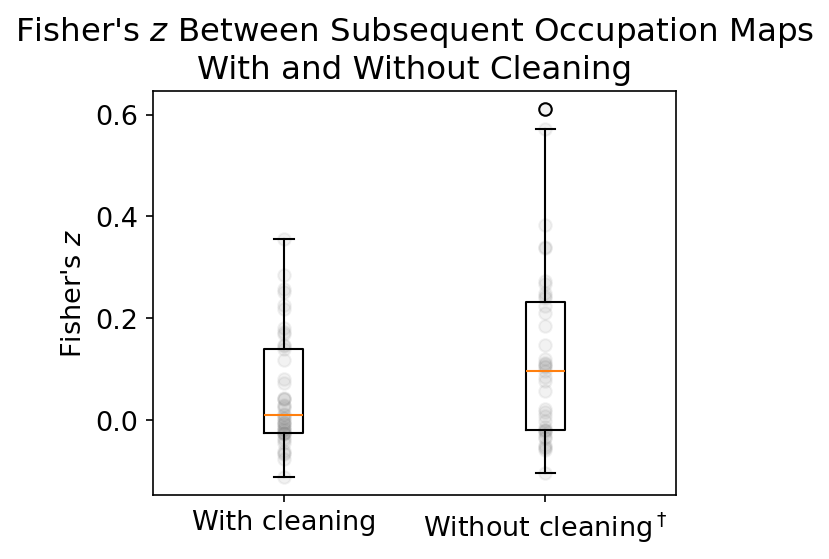

T statistic: -2.1437098058624815
P value: 0.01794338497434432


In [261]:
controlRArr = zArr[controlIndices,:][:,controlIndices]
testRArr = zArr[testIndices,:][:,testIndices]

# We need to use Welch's T-test since the variance of the two
# sets of values is different (see the +/- values above)
N1 = len(controlRArr) - 1
N2 = len(testRArr) - 1

# Grab the elements next to the diagonal (ie. subsequent trials)
x = controlRArr[np.arange(N1), np.arange(N1)+1]
y = testRArr[np.arange(N2), np.arange(N2)+1]

x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

plt.scatter(np.zeros(len(x))+1, x, alpha=0.1, c='gray')
plt.scatter(np.zeros(len(y))+2, y, alpha=0.1, c='gray')

plt.boxplot([x, y], sym='o')
plt.xticks([1, 2], ['With cleaning', 'Without cleaning$^\\dagger$'])
plt.ylabel('Fisher\'s $z$')
plt.title('Fisher\'s $z$ Between Subsequent Occupation Maps\nWith and Without Cleaning')
plt.gcf().set_size_inches((4.5,3.5))
plt.show()

# If you take the mean of these x and y you should get the
# statistics printed out above
# 'less' because the alternative hypothesis to these distributions
# being equal is that the correlations for cleaned trials is less
# than that of uncleaned ones
tStat, pVal = stats.ttest_ind(x, y, equal_var=False, alternative='less')
print(f'T statistic: {tStat}')
print(f'P value: {pVal}')

/tmp/ipykernel_94810/2640159148.py:4: RuntimeWarning: invalid value encountered in multiply
  nonDiagRArr = nonDiagRArr * (np.ones_like(nonDiagRArr) - np.eye(len(nonDiagRArr)))


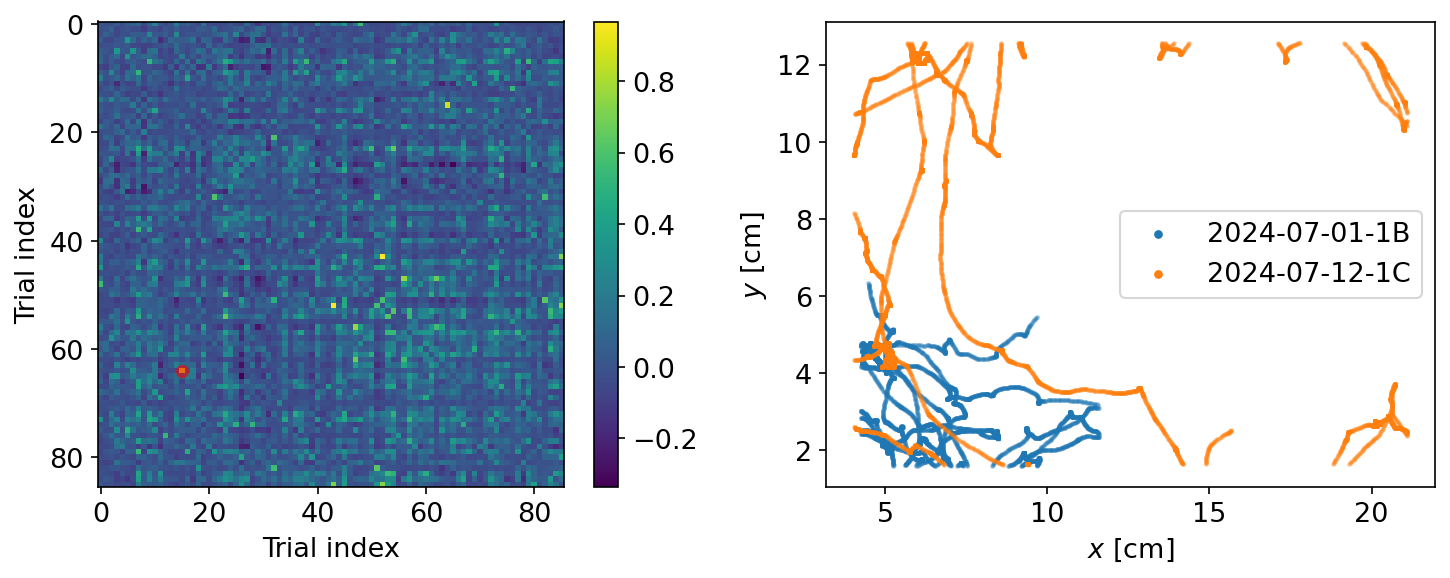

In [258]:
# Compare specific trials
maxIndex = 1
nonDiagRArr = zArr.copy()
nonDiagRArr = nonDiagRArr * (np.ones_like(nonDiagRArr) - np.eye(len(nonDiagRArr)))
nonDiagRArr[np.where(np.eye(len(nonDiagRArr)))] = 0

sortedIndices = np.argsort(nonDiagRArr, axis=None)[::-1]

raveledIndices = np.array([np.sort(np.unravel_index(i, nonDiagRArr.shape)) for i in sortedIndices])

i,j = raveledIndices[maxIndex*2]

fig, ax = plt.subplots(1, 2, figsize=(10,4))

im = ax[0].imshow(nonDiagRArr)
ax[0].scatter(i,j, s=30, c='red', alpha=0.5)
ax[0].set_xlabel('Trial index')
ax[0].set_ylabel('Trial index')
fig.colorbar(im)
colors = ['tab:blue', 'tab:orange']
segmentTrialIdentity = np.array([indexDict[metadataArr[l]["dataset"]] for l in range(len(dataArr))])

for ki, k in enumerate([i,j]):
    ax[1].scatter([], [], c=colors[ki], s=10, label=metadataArr[np.where(segmentTrialIdentity == k)[0][0]]["dataset"])

    for l in np.where(segmentTrialIdentity == k)[0]:
        ax[1].scatter(*dataArr[l].T / 10, c=colors[ki], s=2, alpha=0.3)

ax[1].set_xlabel('$x$ [cm]')
ax[1].set_ylabel('$y$ [cm]')

ax[1].legend()
fig.tight_layout()
plt.show()